In [1]:
# import cudf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# import cupy
import glob
import time

### Loading and Analyzing JSON Data
We will begin by loading json data with a small subset of around 100k as the original dataset is quite big, and we may run out of RAM computing that.

In [2]:
%%time
train_df = pd.DataFrame()
chunks = pd.read_json('otto-recommender-system/train.jsonl', lines=True, chunksize=100_000)

for chunk in chunks:
    event_dict = {'session': [], 'aid': [], 'ts': [], 'type': []}

    for session, events in zip(chunk['session'].to_list(), chunk['events'].to_list()):
        for event in events:
            event_dict['session'].append(session)
            event_dict['aid'].append(event['aid'])
            event_dict['ts'].append(event['ts'])
            event_dict['type'].append(event['type'])
    train_df = pd.DataFrame(event_dict)
    break

train_df = train_df.reset_index(drop=True)
train_df

CPU times: user 4.49 s, sys: 634 ms, total: 5.12 s
Wall time: 5.14 s


,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
5227648,99999,1544954,1660373630318,clicks
5227649,99999,1032408,1660373656430,clicks
5227650,99999,1544954,1660373678083,clicks
5227651,99999,554230,1660373715477,clicks


We observe that there are three types of events here clicks, carts and orders, so let's check if there are any correlation amongst these events, since we are looking at an Multi-Objective Recommender System, we would want to be able to estabilish how the user's purchasing history was determined for generating better recommendations.

Since the features in consideration are categorical variables, we will use 2x2 contingency table and corr() metrics to estabilish correlation.

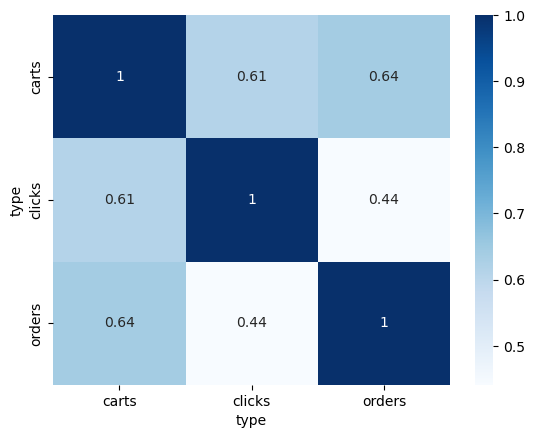

In [3]:
ct = pd.crosstab(index=train_df['session'], columns=train_df['type'])
sns.heatmap(ct.corr(), cmap='Blues', annot=True)
plt.show()

we observe that there is 61% probability of clicks being put into carts. 64% probability that the items in carts are being ordered.

In [4]:
del train_df, ct 

### Loading Data and Creating a Recommender System based on Matrix Factorization
We will proceed with using the otto-full-optimized-memory-footprint dataset since it is a compressed version with libraries like Merlin, and cuDF, we will proceed with creating a model.

In [5]:
#we need to create columns specifically for type, time-stamps and aid which is the unique id
# lets time the process
%time

train_df = pd.read_parquet('otto-recommender-system/otto-full-optimized-memory-footprint/train.parquet')
test_df = pd.read_parquet('otto-recommender-system/otto-full-optimized-memory-footprint/test.parquet')

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 5.72 μs


We need to create aid-aid pairs to train our matrix factorization model!

Let's us grab the pairs both from the train and test set.

In [ ]:
%time
train_pairs = pd.concat([train_df, test_df])[['session','aid']]

del train_df, test_df

train_pairs['aid_next'] = train_pairs.groupby('session').aid.shift(-1)
train_pairs = train_pairs[['aid', 'aid_next']].dropna().reset_index(drop=True)

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 10 μs


,session,aid
0,0,1517085
1,0,1563459
2,0,1309446
3,0,16246
4,0,1781822
...,...,...
6928118,14571577,1141710
6928119,14571578,519105
6928120,14571579,739876
6928121,14571580,202353


cardinality means possible values the feature can assume, so here it is possible that 'aid' column can have many values.

In [ ]:
cardinality_aids = max(train_pairs['aid'].max(), train_pairs['aid_next'].max())
cardinality_aids